# Style Transfer with Deep Neural Netoworks

We'll recreate a style transfer method that is outlined in the paper, Image Style Transfer Using Convolutional Neural Netwoks, by Gatys in Pytorch.

https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf

In this paper, style transfer uses the features in the 19-layer VGG Network, which is comprised of a series of convolutionl and pooling layers, and a few fully-connected layers. In the image below, the convolutinal layers are named by stack andf their order in the stack. Conv_1_1 is the first convolutinal layer that an image is passed through, in the first stack. Conv_2_1 is the first convolutinal layer in the second stack. The deepest convolutinal layer in the network is conv_5_4.

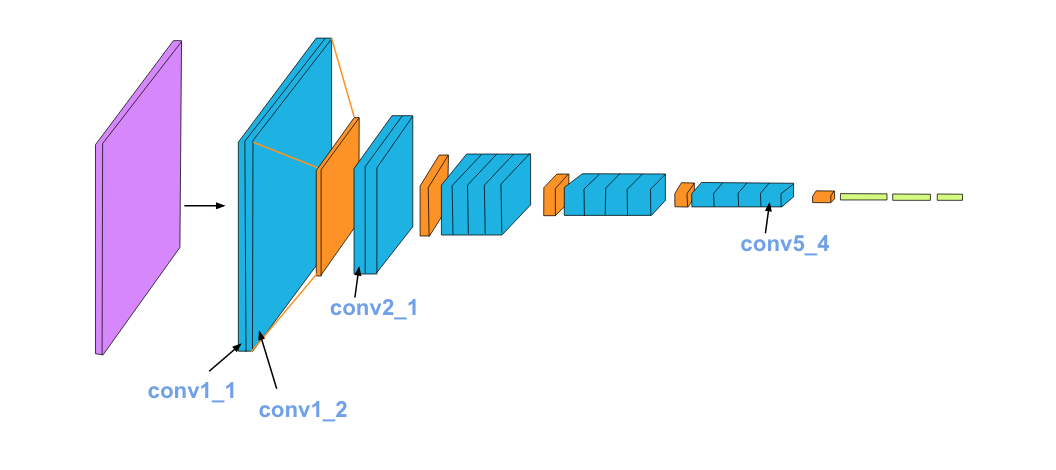

**Separating Style and Content**
Style transfer relies on separating the content and style of an image. Given one content image and one style image, we aim to create a new, target image which should contain our desired content and style components:

* Objects and their arrangemnet atre similar to that of Content Image.
* Style, colors, and textures are similar to that of the Style Image.

An example is shown below, where the content image is of a cat, and the style image is of #Hokusai's Great Wave#.The generated target image still contains the cat but is stylized with the waves, blue and beige colors,and block print textures of the style image!.

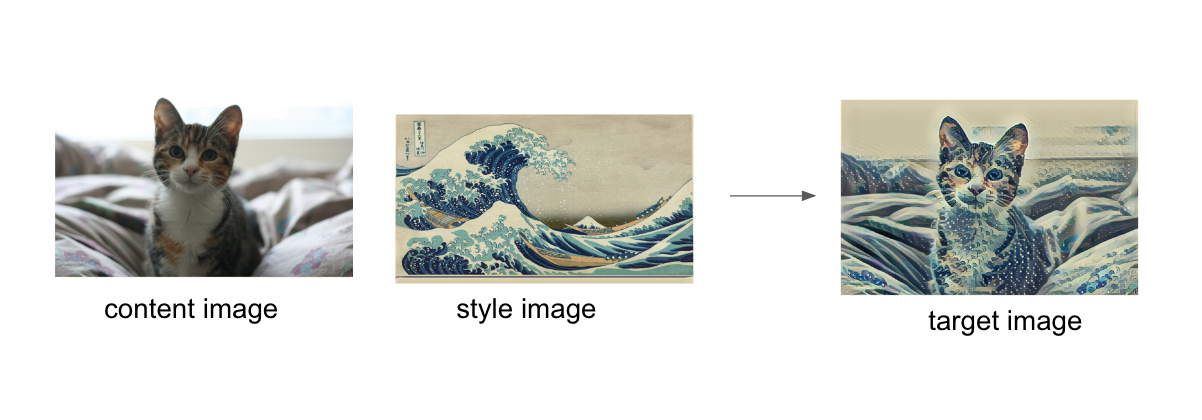




Here, we'll use pre-trained VGG19 Net to extract content or style features from a passed in image. We'll then formalize the idea of content and style losses and use those to itervatively update our target image until we get a result that we want.

In [ ]:
# import resources
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

**Load in VGG19 (Features)**

VGG19 is split into two options:
*   vgg19.features, which are all the convolutional and pooling layers
*   vgg19.classifier, which are the three linear, classifier layers at the end

we only need the features portion, which we're going to load in and "freeze" the weights of, below.



In [ ]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad = False


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 75.7MB/s]


In [ ]:
#  move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

**Load in Content and Style Images**

You can load in any images you want! Below, we've provided a helper function for loading in any type and size of images. The load_image function also converts images to normalized Tensors.

Additionally, it will be easier to have smaller images and to squish the content and style images so that they are of the same size.

In [ ]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
        is <=400 pixels in the z-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')

    # Large image will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])

    # Discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3, :, :].unsqueeze(0)

    return image


Next, I'm loading in images by file name and forcing the style image to be the same size as the content image.

In [ ]:
# Load in content and style image
content = load_image('octopus.png').to(device)
# Resize style to match content, makes code easier
style = load_image(('Hockney.png'), shape=content.shape[-2:]).to(device)


In [ ]:
# Helper function for un-normalizing an image
# and converting  it from a Tensor image to a Numpy image for display
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose((1, 2, 0))  # Corrected transpose syntax
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image


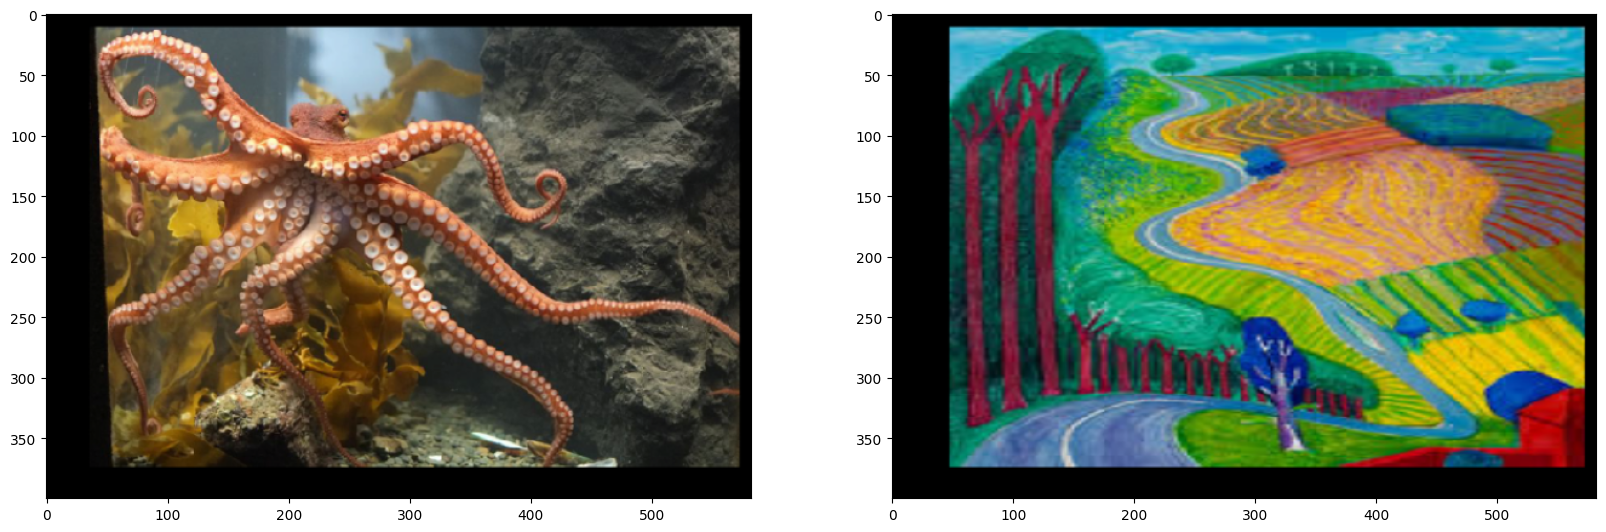

In [ ]:
# Display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# Content and style in side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

# **VGG19 Layers**

To get the content and style representation of an image, we have to pass an image forward through the VGG19 network until we get to the desired layer(s) and then get the output from that layer.

In [ ]:
# print out VGG19 structure so you see the names of various layers
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# **Content and Style features**
Below, complete th emapping of layer names to the names found in the paper for the content representation and the style representation.

In [ ]:
def get_features(image, model, layers=None):
    """Run an image forward through a model and get the features for
    a set of layers. Default layers are for VGGNet matching Getys et al. (2016)
    """

    # TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    # Need the layers for the content and style representation of an image

    if layers is None:
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',  ## Content Representation
            '28': 'conv5_1'
        }

    features = {}
    x = image

    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features


# **Gram Matrix**

The output of every convolutional layer is a Tensor with dimesions associated with the batch_size, a depth, d and some height and width (h,w). The Gram matrix of a convolutional layer can be calculated as follows:

*  Get the depth, height amnd width of a tensor using batch_size, d, h, w = tensor.size
*  Reshape that tensor so that the spatial dimesions are flattened
*  Calculate the gram matrix by multiplying the reshaped tensor by it's trasnpose

Note: You can multiply two matrices using torch.mm(matrix1, matrix2)






In [ ]:
def gram_matrix(tensor):
  """ Calculate the Gram matrix of a given tensor
      Gram Matrix: https://en.wikipedia.org/wiki/Gram_matrix
  """

  # Get the batch_size, depth, height, and width of the Tensor
  b, d, h, w = tensor.size()

  # reshape so we're multiplying the features for each channel
  tensor = tensor.view(b * d, h * w)

  # Calculate the gram matrix
  gram = torch.mm(tensor, tensor.t())

  return gram

# **Putting it all Together**

Now that we've writtem functions for extracting features and computing the gram matrix of a givem convoltional layer; let's pull all these pieces together! We'll extract our features from our images and calculate the gram matrices for each layer in our style representation.

In [ ]:
# Get the content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer : gram_matrix(style_features[layer]) for layer in style_features}

# Create a third "target" image and prep it for change
# It is a good idea to start off the with the target as a copy of our *content* image
# then itervatively change its style

target = content.clone().requires_grad_(True).to(device)

# **Loss and Weights**








**Individual Layer Style Weights**







Below, you are given the option to weight the style represenatation at each relevant layer.It's suggested that you you use a range between 0-1 to weight these layers. By weighting earlier layers (conv1_1 and conv2_1) more,you can expert to get the largerstyle artifacts in your resulting, target image. Should you choose to weight layer layers, you'll get more emphasis on smaller features.This is beacuse each layer is a different size and together they create a multi-scale style representation!







**Content and Style Weight**









Just like in the paper, we define an alpha (content_weight) and a beta (style_weight). This ratio will affect how stylized your final image is. It's recommended that you leave the content_weight = 1 and set the style_weight to achieve the ratio you want.



In [ ]:
# Weights for each style layer
# Weighting earlier layers more result in *larger* style artifacts
# notice we are excluding 'conv4_2' our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}
content_weight = 1 # alpha
style_weight = 1e6 # beta


# **Updating the Target & Calculating Losses**

You'll decide on a number of steps for which to update your image, this is similar to the training loop that you've seen before, only we are changing our target image and nothing else about VGG19 or any other image. Tehrefore, the number if steps is really up to you yo set! I recommend using atleast 2000 steps for good results. But, you may want to start out with fewer steps if you are just testing out differenr weight values or experimenting with different images.

Inside the iteration loop, you'll calculate the content and style losses and update your target image, accordingly.

** Content Loss **
The content loss will be the mean squared difference between the target and content features at layer conv4_2. This can be calculated as follows:

content_loss = torch.mean((target_features['conv4_2']- content_features['conv4_2'])**2)

** Style loss **
The style loss is calculated in a similar way, only you have to iterate through a number of layers, specified by name in our dictionary # style_weights #.

-> will calculate the gram matrix for target image, target_gram and style image style_gram at each of these layers and compare those gram matrices, calculating the layer_style_loss. Later, you'll see that this value is normalized nby the size of the layer.


** Total Loss **





Finally, will create the total loss by adding up the style and content loss and weighting them with your specified alpha and beta!

Intermittently, we'll print out this loss; don't be alarmed if the loss is very large. It takes some time for an image's style to change and you should focus on the appearance of your target image rather than any loss value. Still, you should see that this loss decreases over some number of iterations.



Total loss:  311536128.0


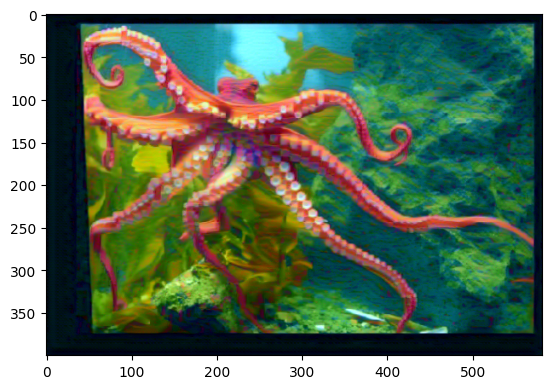

Total loss:  95278040.0


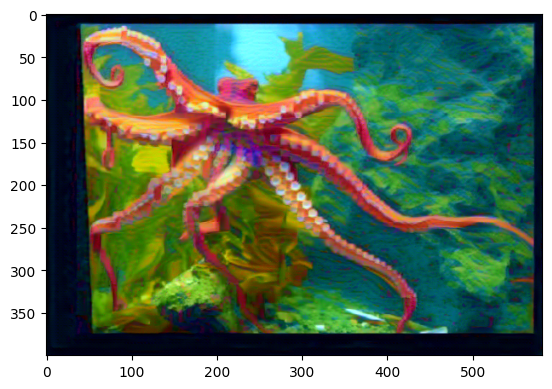

In [ ]:
import torch.optim as optim

# For displaying the target image intermittently
show_every = 400

# Iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # Decide how many iterations to update your image (5000)

# Initialize h, w, and d here with appropriate values based on your target image size
h, w, d = target.shape[-3:]

for ii in range(1, steps + 1):
    # Get the features from your target image
    target_features = get_features(target, vgg)

    # The content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # The style loss
    # Initialize the style loss to 0
    style_loss = 0
    # Then add to it each layer's gram matrix loss
    for layer in style_weights:
        # Get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        # Get the "style" style representation
        style_gram = style_grams[layer]
        # The style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # Add to the style loss
        style_loss += layer_style_loss / (d * h * w)  # Using the initialized values of h, w, and d

    # Calculate the total loss
    total_loss = content_weight * content_loss + style_weight * style_loss

    # Update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Display intermediate images and print the loss
    if ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()


#**Display the target image**

In [ ]:
# Display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))